## Looking at the poll data

In [93]:
# polls are inside italian_polls.jsonl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


polls = pd.read_json('italian_polls.jsonl', lines=True)

# data inserimento is in the format 'dd/mm/yyyy'
# renaming Data Inserimento to date
polls = polls.rename(columns={'Data Inserimento': 'date'})
polls['date'] = pd.to_datetime(polls['date'], format='%d/%m/%Y')

# filtering out bad/unappropriate data - data where more than 3 parties have nan values
polls = polls.dropna(thresh=2)

# columns after the 8th should be floats
# turning digit,1 into digit.1 and digit% into digit
polls.iloc[:, 8:] = polls.iloc[:, 8:].replace({',': '.'}, regex=True)
polls.iloc[:, 8:] = polls.iloc[:, 8:].replace({'%': ''}, regex=True)

# cast into float and discard the non castable values
polls.iloc[:, 8:] = polls.iloc[:, 8:].apply(pd.to_numeric, errors='coerce')
# make sure they are all floats
polls.iloc[:, 8:] = polls.iloc[:, 8:].astype(float)

# apply float to the cols after the 8th
for col in polls.columns[8:]:
    polls[col] = polls[col].apply(float)
    
# remove polls where the col sum is more than 5% off from 100%
polls = polls[abs(polls.iloc[:, 8:].sum(axis=1) - 100) < 6]

# if there is no Partito Democratico or Fratelli d'Italia, drop the poll
polls = polls.dropna(subset=['Partito Democratico', "Fratelli d'Italia"])


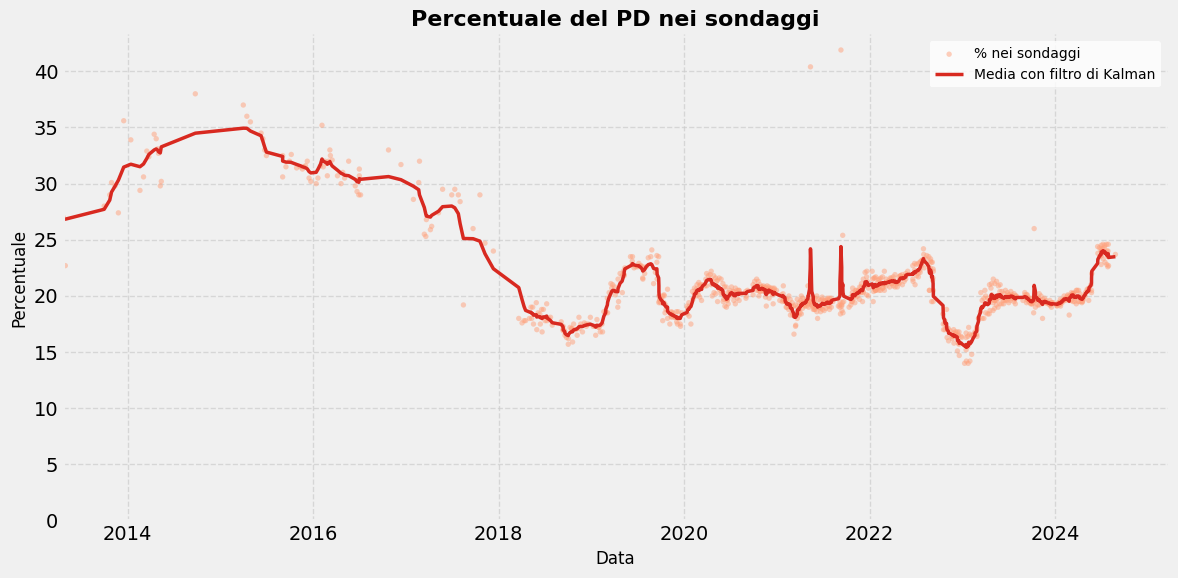

In [94]:
# plot PD vote over time
from pykalman import KalmanFilter
import matplotlib.dates as mdates

plt.style.use('fivethirtyeight')

# Prepare the data
pd_votes = polls[['date', 'Partito Democratico']]
pd_votes = pd_votes.set_index('date')
pd_votes = pd_votes.dropna()

# Convert to numpy array for Kalman filter
observations = pd_votes['Partito Democratico'].values

# Set up the Kalman Filter with less smoothing
kf = KalmanFilter(
    initial_state_mean=observations[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

# Apply the Kalman Filter
state_means, _ = kf.smooth(observations)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light grey)
ax.scatter(pd_votes.index, pd_votes['Partito Democratico'], 
           color='lightsalmon', alpha=0.5, s=15, edgecolors='none', label='% nei sondaggi')

# Plot the Kalman filter line (red and slightly thicker)
ax.plot(pd_votes.index, state_means, 
        color='#d82920', linewidth=2.5, label='Media con filtro di Kalman')

# Customize the plot
ax.set_title('Percentuale del PD nei sondaggi', fontsize=16, fontweight='bold')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Percentuale', fontsize=12)
ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0
ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling
ax.set_xlim(left=pd_votes.index[-1])

# Add gridlines
ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Adjust layout and display
plt.tight_layout()
plt.show()

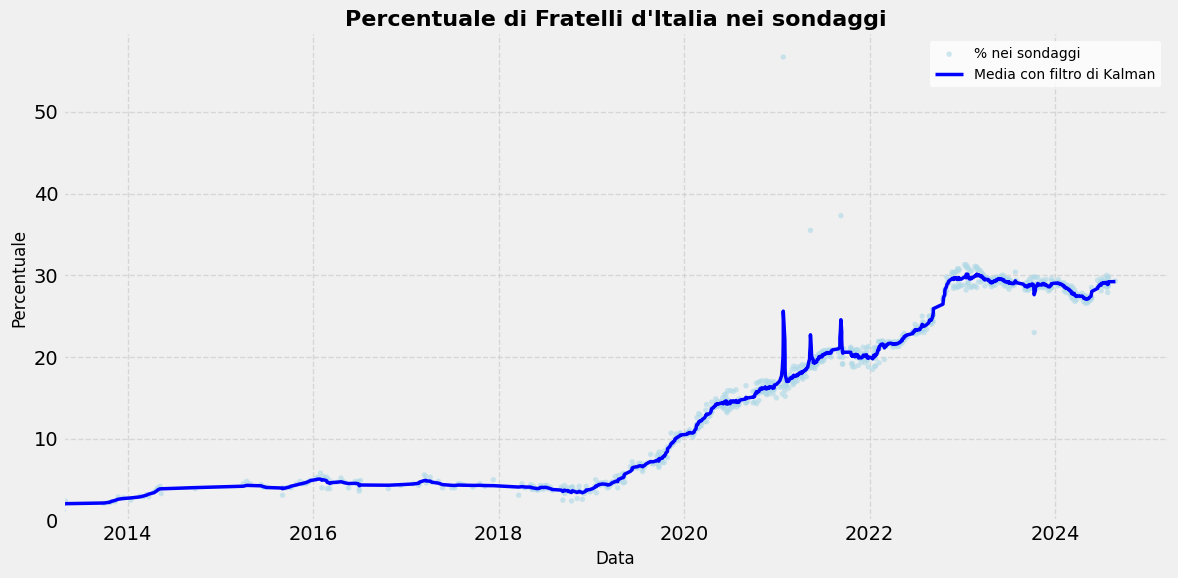

In [95]:
# same for Frateelli d'Italia

# Prepare the data
fdi_votes = polls[['date', 'Fratelli d\'Italia']]
fdi_votes = fdi_votes.set_index('date')
fdi_votes = fdi_votes.dropna()

# Convert to numpy array for Kalman filter

observations = fdi_votes['Fratelli d\'Italia'].values

# Set up the Kalman Filter with less smoothing

kf = KalmanFilter(
    initial_state_mean=observations[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

# Apply the Kalman Filter

state_means, _ = kf.smooth(observations)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light blue)

ax.scatter(fdi_votes.index, fdi_votes['Fratelli d\'Italia'],
                      color='lightblue', alpha=0.6, s=15, edgecolors='none', label='% nei sondaggi')

ax.plot(fdi_votes.index, state_means,
        color='blue', linewidth=2.5, label='Media con filtro di Kalman')

# Customize the plot

ax.set_title('Percentuale di Fratelli d\'Italia nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0

ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=fdi_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()

817 817 817 817


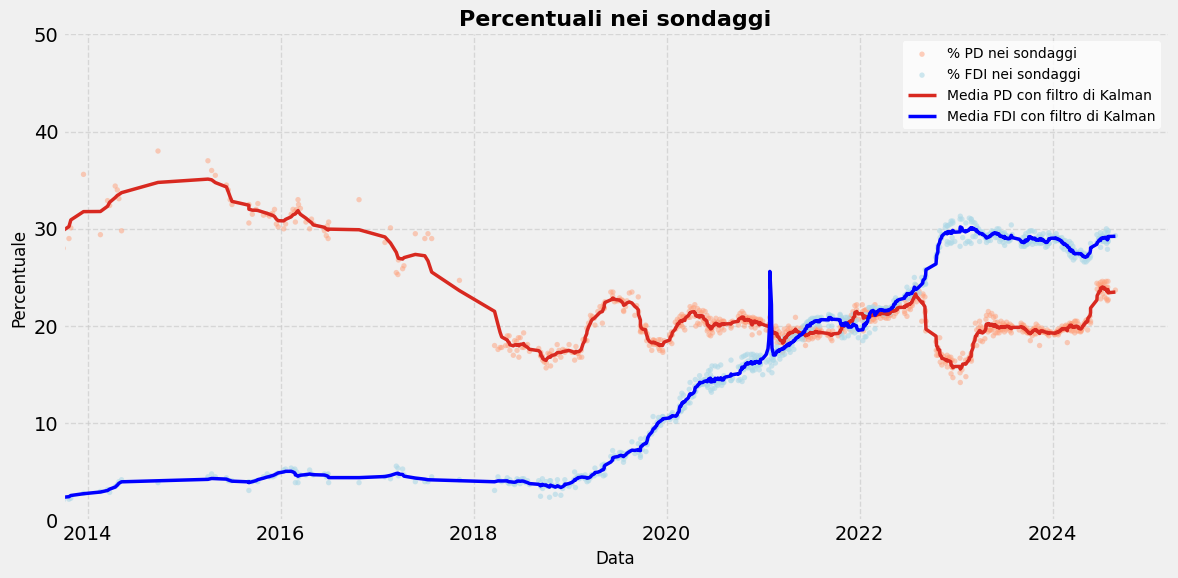

In [96]:
# both of them in one plot with y axis capped at 50

# pd_votes and fdi_votes are already prepared

# pd_votes and fdi_votes should have the same length
assert len(pd_votes) == len(fdi_votes)

# 2 kalman filters
observations_pd = pd_votes['Partito Democratico'].values
observations_fdi = fdi_votes['Fratelli d\'Italia'].values



# from obs, get index of big jumps so we can remove them
def get_big_jumps(obs):
    jumps = []
    for i in range(1, len(obs)):
        if abs(obs[i] - obs[i - 1]) > 2:
            jumps.append(i)
    return jumps

# get the jumps

jumps_pd = get_big_jumps(observations_pd)
jumps_fdi = get_big_jumps(observations_fdi)

# remove the jumps

for jump in jumps_pd:
    observations_pd[jump] = np.nan
    observations_fdi[jump] = np.nan

# the dataframes should be adapted to the new observations
pd_votes['Partito Democratico'] = observations_pd
fdi_votes['Fratelli d\'Italia'] = observations_fdi

# remove the nans
pd_votes = pd_votes.dropna()
fdi_votes = fdi_votes.dropna()

# count nan values
assert pd_votes.isnull().sum().sum() == 0
assert fdi_votes.isnull().sum().sum() == 0

# also from the observations
observations_pd = pd_votes['Partito Democratico'].values
observations_fdi = fdi_votes['Fratelli d\'Italia'].values
    
# len fdi_votes and pd_votes should be the same
assert len(fdi_votes) == len(pd_votes)
assert len(observations_pd) == len(observations_fdi)
assert len(observations_pd) == len(pd_votes)


print(len(observations_pd), len(observations_fdi), len(pd_votes), len(fdi_votes))
kf_pd = KalmanFilter(
    initial_state_mean=observations_pd[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

kf_fdi = KalmanFilter(
    initial_state_mean=observations_fdi[0],
    initial_state_covariance=1.0,
    observation_covariance=0.5,  # Reduced from 0.5 for less smoothing
    transition_covariance=0.11,   # Increased from 0.1 for less smoothing
    transition_matrices=[1],
    observation_matrices=[1]
)

state_means_pd, _ = kf_pd.smooth(observations_pd)

state_means_fdi, _ = kf_fdi.smooth(observations_fdi)

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points with same colors from before

ax.scatter(pd_votes.index, pd_votes['Partito Democratico'],
           color='lightsalmon', alpha=0.5, s=15, edgecolors='none', label='% PD nei sondaggi')

ax.scatter(fdi_votes.index, fdi_votes['Fratelli d\'Italia'],
           color='lightblue', alpha=0.6, s=15, edgecolors='none', label='% FDI nei sondaggi')

# Plot the Kalman filter lines with same colors from before

ax.plot(pd_votes.index, state_means_pd,
        color='#d82920', linewidth=2.5, label='Media PD con filtro di Kalman')

ax.plot(fdi_votes.index, state_means_fdi,
        color='blue', linewidth=2.5, label='Media FDI con filtro di Kalman')

# Customize the plot

ax.set_title('Percentuali nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0 and cap at 50

ax.set_ylim(bottom=0, top=50)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=pd_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()

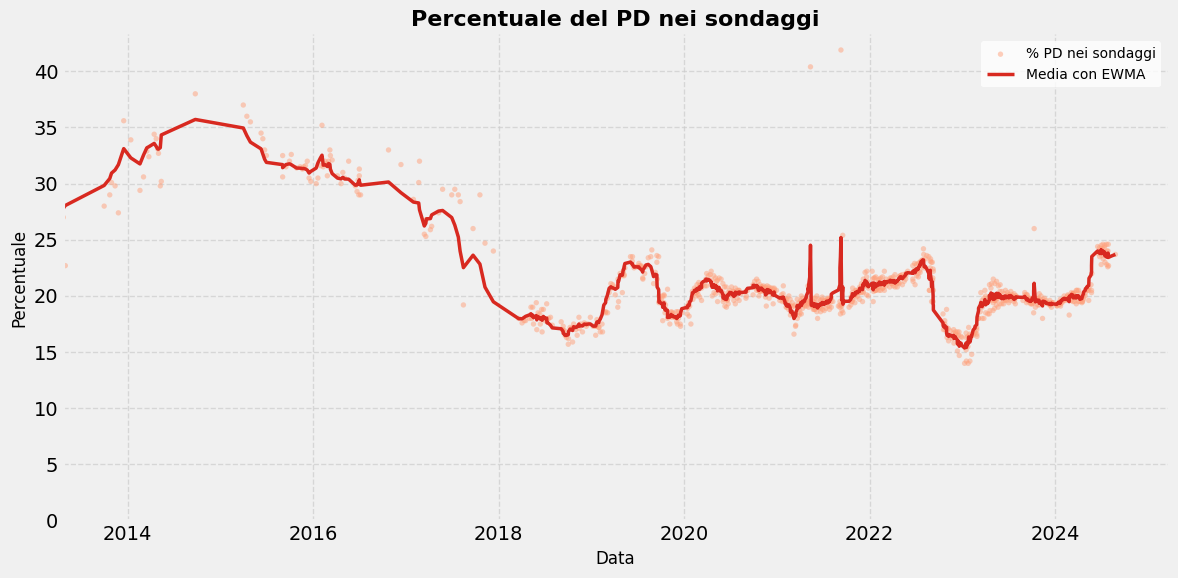

In [97]:
# stessa cosa ma usando l'exponentially weighted moving average

# Prepare the data

pd_votes = polls[['date', 'Partito Democratico']]

pd_votes = pd_votes.set_index('date')

pd_votes = pd_votes.dropna()

# Calculate the exponentially weighted moving average
pd_votes['ewma'] = pd_votes['Partito Democratico'].ewm(span=7,adjust=False).mean()

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light grey)

ax.scatter(pd_votes.index, pd_votes['Partito Democratico'],
              color='lightsalmon', alpha=0.5, s=15, edgecolors='none', label='% PD nei sondaggi')

# Plot the exponentially weighted moving average line (red and slightly thicker)

ax.plot(pd_votes.index, pd_votes['ewma'],
        
        color='#d82920', linewidth=2.5, label='Media con EWMA')

# Customize the plot

ax.set_title('Percentuale del PD nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0

ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=pd_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()

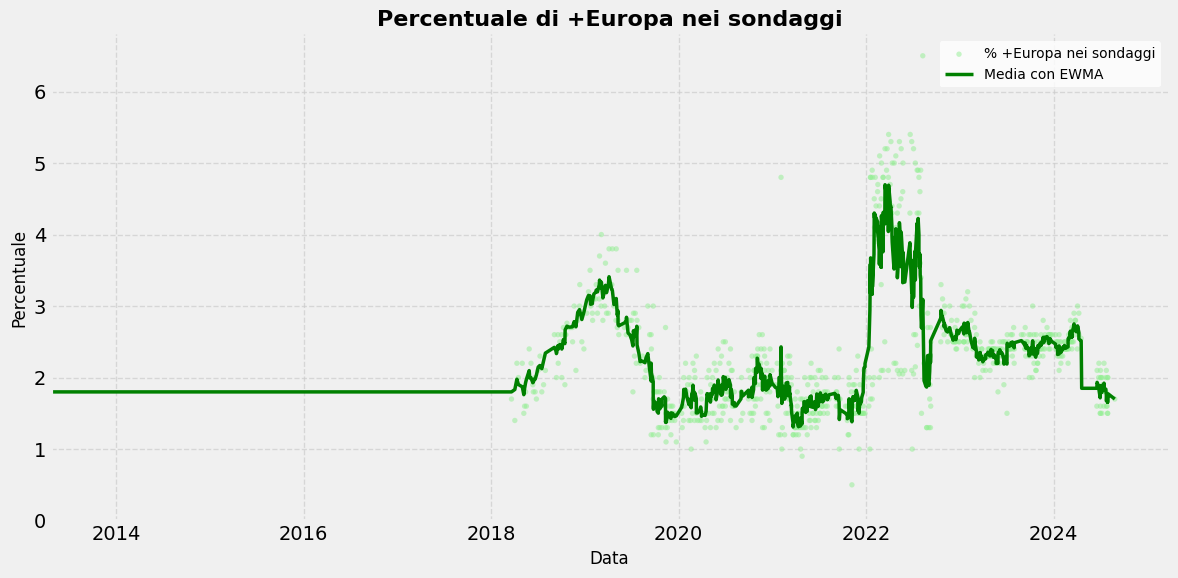

In [106]:
# investigating gaps in the data

# plot +europa ewm 

# Prepare the data

europa_votes = polls[['date', '+Europa']]

europa_votes = europa_votes.set_index('date')


# Calculate the exponentially weighted moving average

europa_votes['ewma'] = europa_votes['+Europa'].ewm(span=7, adjust=False).mean()

# Find the indices where there are NaN values
nan_indices = europa_votes['+Europa'].isnull()

# Plot the scatter points with breaks on NaN values
ax.scatter(europa_votes.index[~nan_indices], europa_votes['+Europa'][~nan_indices],
           color='lightgreen', alpha=0.5, s=15, edgecolors='none', label='% +Europa nei sondaggi')

# Plot the scatter points with breaks on NaN values
ax.scatter(europa_votes.index[nan_indices], europa_votes['+Europa'][nan_indices],
           color='lightgreen', alpha=0.5, s=15, edgecolors='none', label='% +Europa nei sondaggi')

# Plot the exponentially weighted moving average line (green and slightly thicker)
ax.plot(europa_votes.index, europa_votes['ewma'],
        color='green', linewidth=2.5, label='Media con EWMA')

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the scatter points (smaller and light grey)

ax.scatter(europa_votes.index, europa_votes['+Europa'],

              color='lightgreen', alpha=0.5, s=15, edgecolors='none', label='% +Europa nei sondaggi')

# Plot the exponentially weighted moving average line (green and slightly thicker)

ax.plot(europa_votes.index, europa_votes['ewma'],
            
            color='green', linewidth=2.5, label='Media con EWMA')

# Customize the plot

ax.set_title('Percentuale di +Europa nei sondaggi', fontsize=16, fontweight='bold')

ax.set_xlabel('Data', fontsize=12)

ax.set_ylabel('Percentuale', fontsize=12)

ax.legend(fontsize=10, frameon=True, facecolor='white', edgecolor='none')

# Set y-axis to start at 0

ax.set_ylim(bottom=0)

# Set x-axis to start at the first day of polling

ax.set_xlim(left=europa_votes.index[-1])

# Add gridlines

ax.grid(True, linestyle='--', alpha=0.7, color='#CCCCCC')

# Remove top and right spines

ax.spines['top'].set_visible(False)

ax.spines['right'].set_visible(False)

# Adjust layout and display

plt.tight_layout()

plt.show()
    